In [2]:
import numpy as np
from matplotlib import pyplot as plt
import sys
import math
from mpl_toolkits import mplot3d
from pylab import rcParams
from tqdm import tqdm 
rcParams['figure.figsize'] = 15, 15

### Plot Functions

In [3]:
def plot_data(data_1, data_2, label_1, label_2, markersize_1=8, markersize_2=8):
    ax = plt.axes(projection='3d')
    ax.scatter3D(data_1[0,:], data_1[1,:], data_1[2,:], color='#336699', label=label_1)
    ax.scatter3D(data_2[0,:], data_2[1,:], data_2[2,:], color='orangered', label=label_2)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.legend()
    return ax

In [4]:
def plot_values(values, label):
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    ax.plot(values, label=label)
    ax.legend()
    ax.grid(True)
    plt.show()

In [5]:
def draw_correspondences(P, Q, correspondences, ax):
    label_added = False
    for i, j in correspondences:
        x = [P[0, i], Q[0, j]]
        y = [P[1, i], Q[1, j]]
        z = [P[2, i], Q[2, j]]
        if not label_added:
            ax.plot(x, y, zs=z, color='grey', label='correpondences')
            label_added = True
        else:
            ax.plot(x, y, zs=z, color='grey')
    ax.legend()

### Random Rotation and Translation

In [6]:
theta = math.pi / 3
c, s = np.cos(theta), np.sin(theta)
R_act = np.array(
                    [[c, -s, 0],[s, c, 0], [0, 0, 1]]
                )
t_act = np.array([[-5],[6], [7]])

### Brute Force Data Correspondence 

In [7]:
def get_correspondences(P, Q):
    p_size, q_size = P.shape[1], Q.shape[1]
    correspondences = list()
    for i in range(p_size):
        p_point = P[:, i]
        min_dist = sys.maxsize
        chosen_idx = -1
        for j in range(q_size):
            q_point = Q[:, j]
            dist = np.linalg.norm(q_point - p_point)
            if dist < min_dist:
                min_dist = dist
                chosen_idx = j
        correspondences.append((i, chosen_idx))
    return correspondences

### Mean Centering

In [8]:
def mean_center(S, exclude_indices=[]):
    reduced_data = np.delete(S, exclude_indices, axis=1)
    center = np.array(reduced_data.mean(axis=1)).T
    return center, S - center.reshape(3,1)

### Cross Covariance Matrix

In [9]:
def compute_cross_covariance(P, Q, correspondences, kernel=lambda diff: 1.0):
    cov = np.zeros((3, 3))
    exclude_indices = []
    for i, j in correspondences:
        p_point = P[:, [i]]
        q_point = Q[:, [j]]
        weight = kernel(p_point - q_point)
        if weight < 0.01: exclude_indices.append(i)
        cov += weight * q_point.dot(p_point.T)
    return cov, exclude_indices

### ICP SVD

In [10]:
def icp_svd(P, Q, iterations=10, kernel=lambda diff: 1.0):
    """Perform ICP using SVD."""
    center_of_Q, Q_centered = mean_center(Q)
    norm_values = []
    P_values = [P.copy()]
    P_copy = P.copy()
    corresp_values = []
    exclude_indices = []
    for it in tqdm( range(iterations), desc ="Iteration"):
        center_of_P, P_centered = mean_center(P_copy, exclude_indices=exclude_indices)
        correspondences = get_correspondences(P_centered, Q_centered)
        corresp_values.append(correspondences)
        norm_values.append(np.linalg.norm(P_centered - Q_centered))
        cov, exclude_indices = compute_cross_covariance(P_centered, Q_centered, correspondences, kernel)
        U, S, V_T = np.linalg.svd(cov)
        R = U.dot(V_T)
        t = center_of_Q - R.dot(center_of_P)
        P_copy = R.dot(P_copy) + t.reshape(3, 1)
        P_values.append(P_copy)
    corresp_values.append(corresp_values[-1])
    return P_values, norm_values, corresp_values


### Random Point set generation P, Q

### 100 points

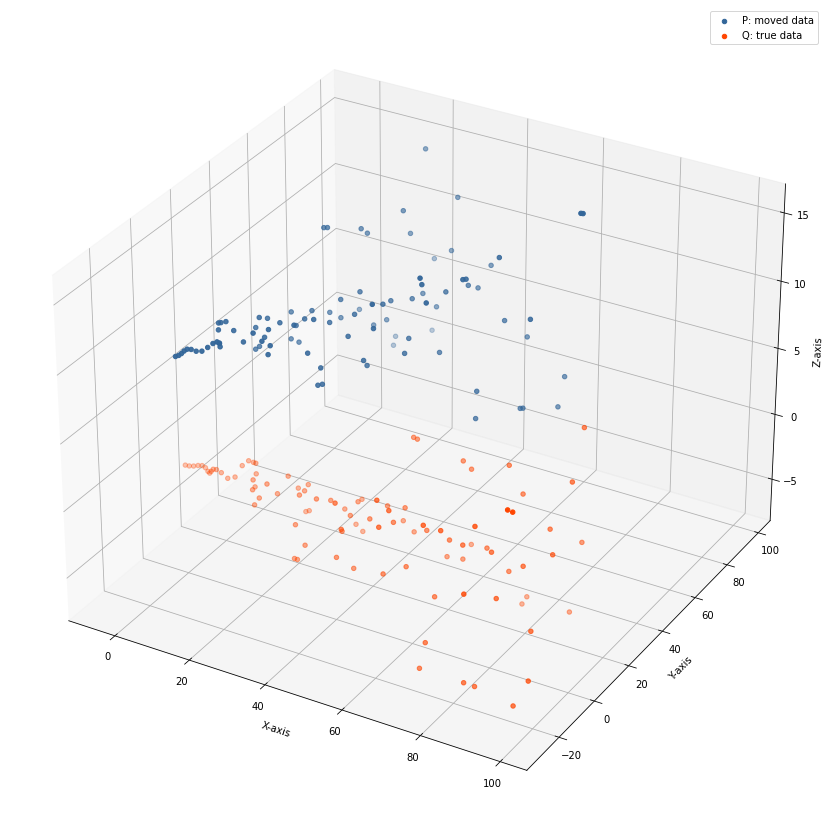

In [11]:
num_points = 100
Q = np.zeros((3, num_points))
Q[0, :] = range(0, num_points)
Q[1, :] = .3 * Q[0, :] * np.sin(.5 * Q[0, :])
Q[2, :] = .3 * Q[1, :] * np.sin(.5 * Q[1, :])

P = R_act.dot(Q) + t_act  # moved data

plot_data(P, Q, "P: moved data", "Q: true data")
plt.ioff()
plt.show()

#### Mean Cetering

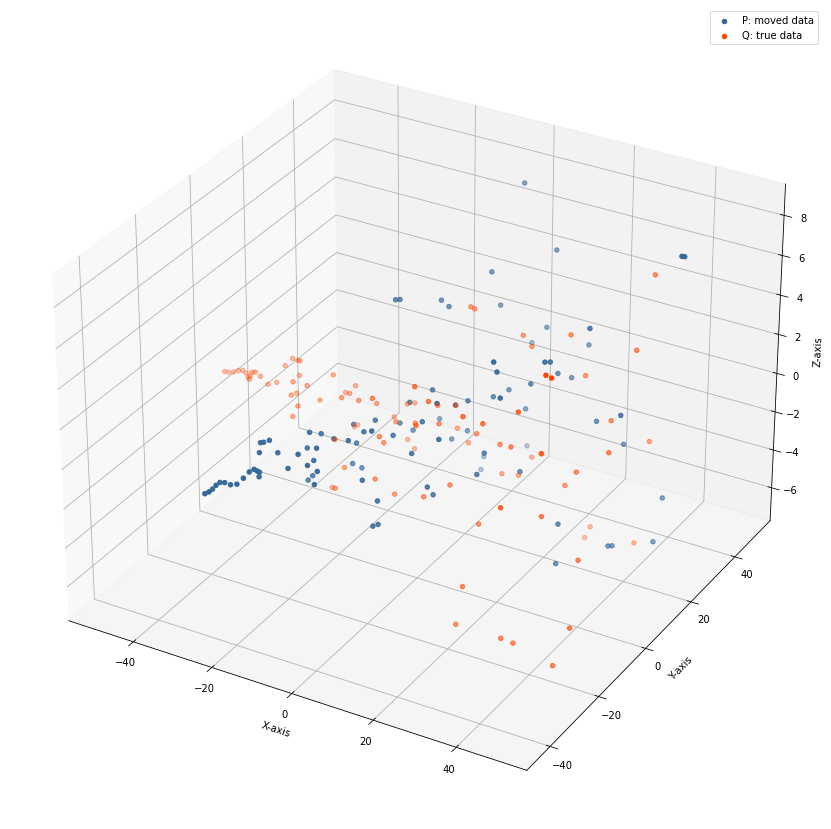

In [12]:
center_P, mean_centered_P = mean_center(P)
center_Q, mean_centered_Q = mean_center(Q)

ax = plot_data(mean_centered_P, mean_centered_Q, "P: moved data", "Q: true data")

plt.show()

#### Compute Correspondences

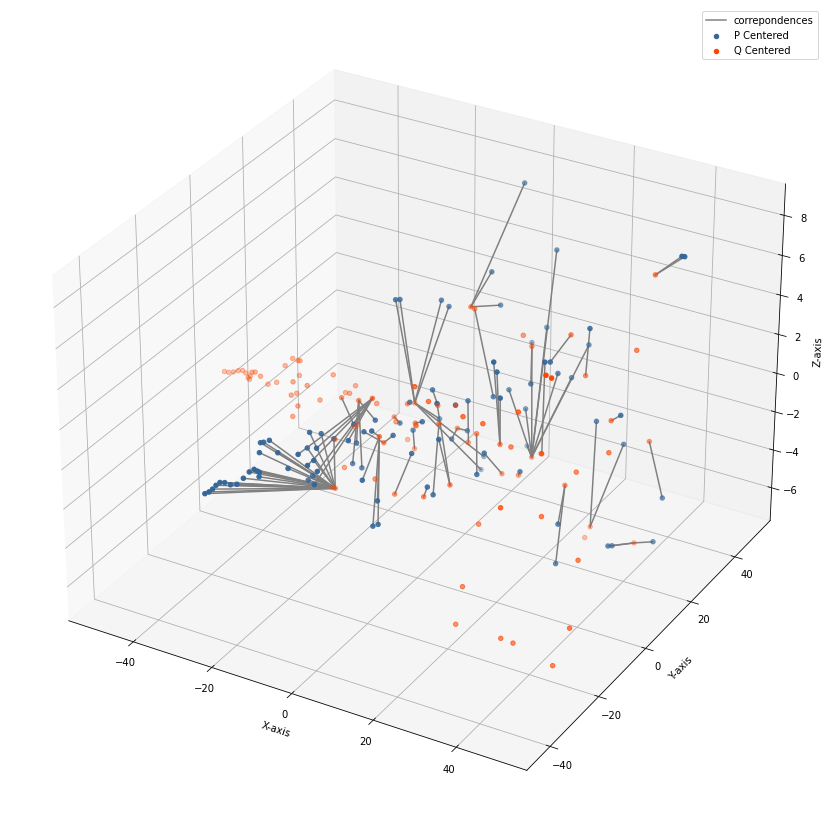

In [13]:
correspondences = get_correspondences(mean_centered_P, mean_centered_Q)
ax = plot_data(mean_centered_P, mean_centered_Q, label_1='P Centered', label_2='Q Centered')
draw_correspondences(mean_centered_P, mean_centered_Q, correspondences, ax)
plt.show()

#### ICP

Iteration: 100%|██████████| 20/20 [00:01<00:00, 15.31it/s]


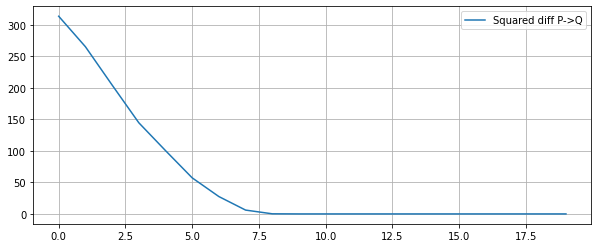

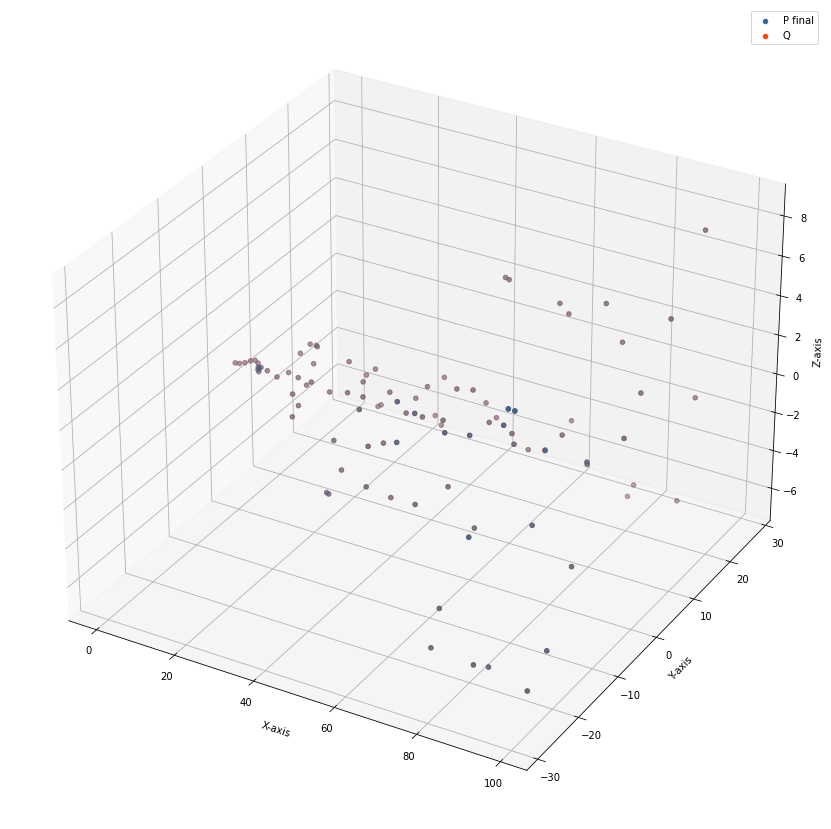

[313.7939925323692, 265.46638258924617, 204.64744550484698, 144.74708339445743, 100.54446851048513, 57.26044777518456, 27.5490240016889, 6.082901398818045, 0.17413633009819549, 6.875160475830917e-13, 7.730347400389601e-13, 8.428149238426106e-13, 8.9199311531104e-13, 1.1189302520661222e-12, 1.2197547493489505e-12, 1.3078882839841902e-12, 1.350187966945897e-12, 1.3129340330531243e-12, 1.3312851261646338e-12, 1.3173855505505161e-12]


In [14]:
P_values, norm_values, corresp_values = icp_svd(P, Q, iterations=20)
plot_values(norm_values, label="Squared diff P->Q")
ax = plot_data(P_values[-1], Q, label_1='P final', label_2='Q', markersize_1=15)
plt.show()
print(norm_values)

### 1000 points

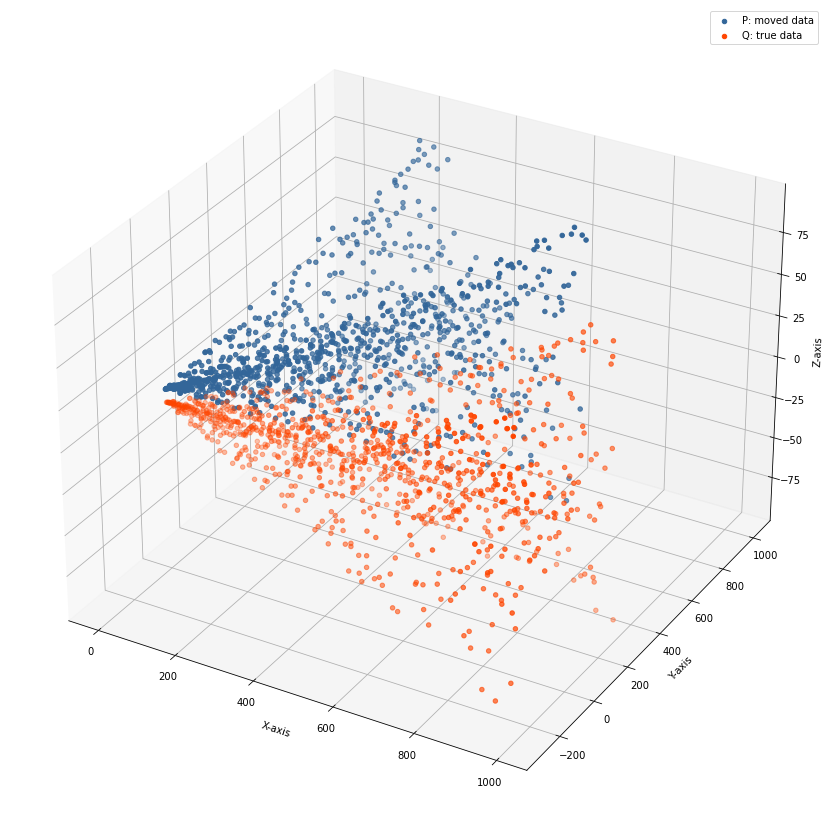

In [14]:
num_points = 1000
Q = np.zeros((3, num_points))
Q[0, :] = range(0, num_points)
Q[1, :] = .3 * Q[0, :] * np.sin(.5 * Q[0, :])
Q[2, :] = .3 * Q[1, :] * np.sin(.5 * Q[1, :])

P = R_act.dot(Q) + t_act  # moved data

plot_data(P, Q, "P: moved data", "Q: true data")
plt.ioff()
plt.show()

#### Mean Centering

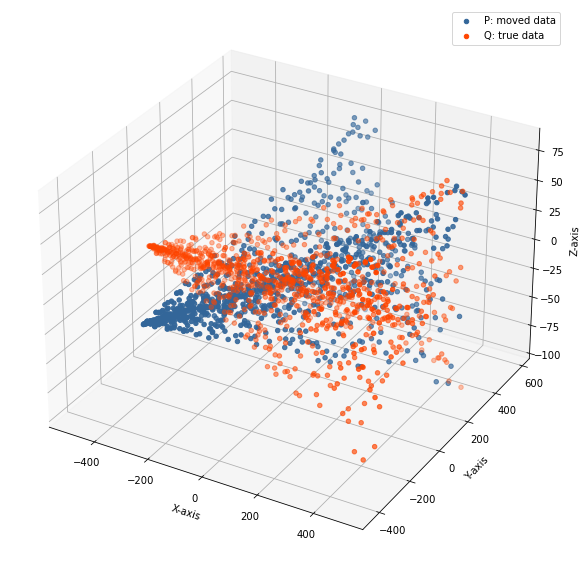

In [15]:
center_P, mean_centered_P = mean_center(P)
center_Q, mean_centered_Q = mean_center(Q)

ax = plot_data(mean_centered_P, mean_centered_Q, "P: moved data", "Q: true data")

plt.show()

#### Compute Correspondences

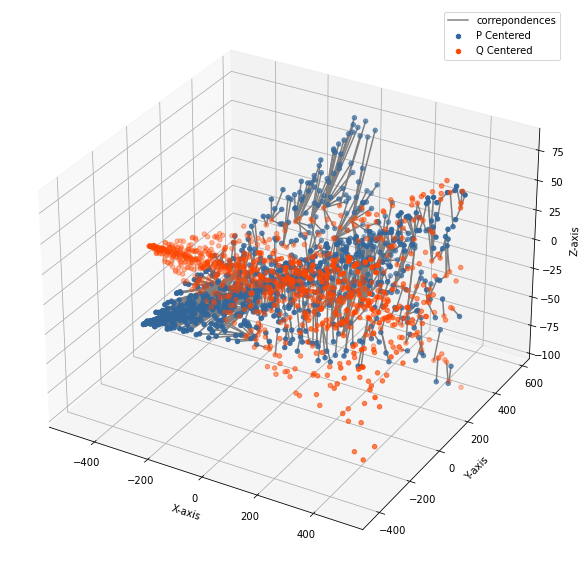

In [16]:
correspondences = get_correspondences(mean_centered_P, mean_centered_Q)
ax = plot_data(mean_centered_P, mean_centered_Q, label_1='P Centered', label_2='Q Centered')
draw_correspondences(mean_centered_P, mean_centered_Q, correspondences, ax)
plt.show()

#### ICP

Iteration: 100%|██████████| 15/15 [01:33<00:00,  6.20s/it]


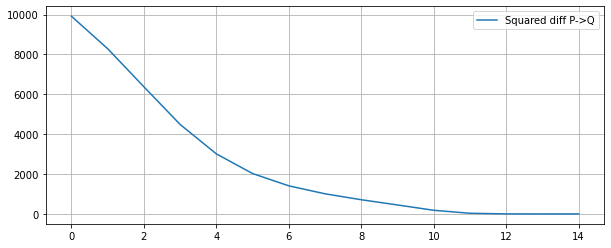

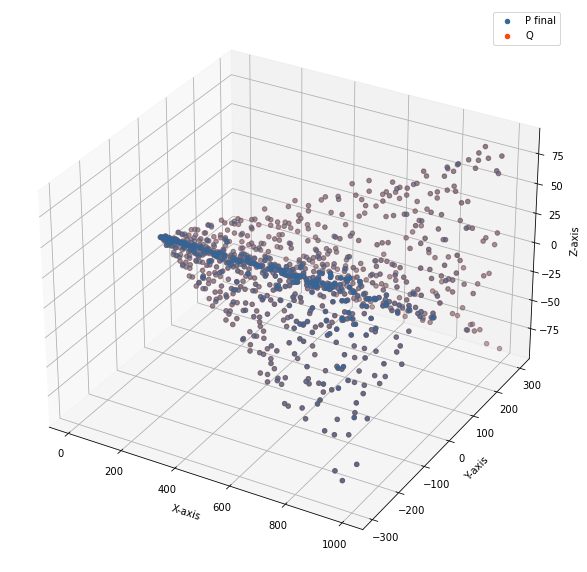

[9914.078551140225, 8285.617037631904, 6374.845578072332, 4486.607122903152, 3009.6935345776255, 2024.3181981411615, 1407.59971424036, 1008.3764364223163, 710.6225543622005, 448.74256643268035, 181.91754545373686, 31.894553869303472, 1.1414620498597812, 1.87676308049348e-11, 2.121401973592795e-11]


In [18]:
P_values, norm_values, corresp_values = icp_svd(P, Q, iterations=15)
plot_values(norm_values, label="Squared diff P->Q")
ax = plot_data(P_values[-1], Q, label_1='P final', label_2='Q', markersize_1=15)
plt.show()
print(norm_values)

### 10,000 points

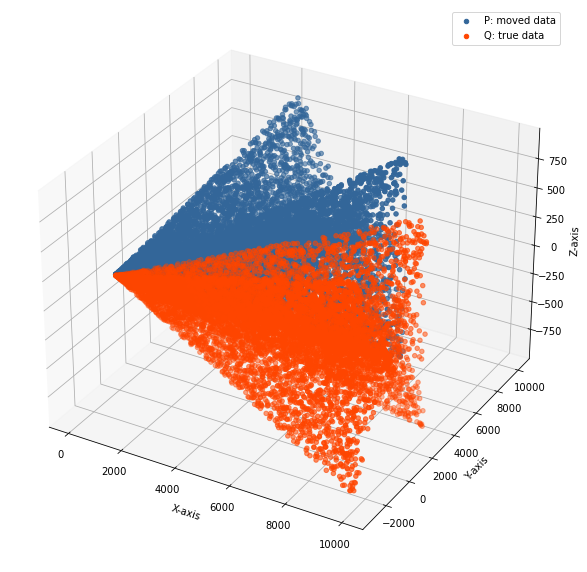

In [19]:
num_points = 10000
Q = np.zeros((3, num_points))
Q[0, :] = range(0, num_points)
Q[1, :] = .3 * Q[0, :] * np.sin(.5 * Q[0, :])
Q[2, :] = .3 * Q[1, :] * np.sin(.5 * Q[1, :])

P = R_act.dot(Q) + t_act  # moved data

plot_data(P, Q, "P: moved data", "Q: true data")
plt.ioff()
plt.show()

#### Mean Centering

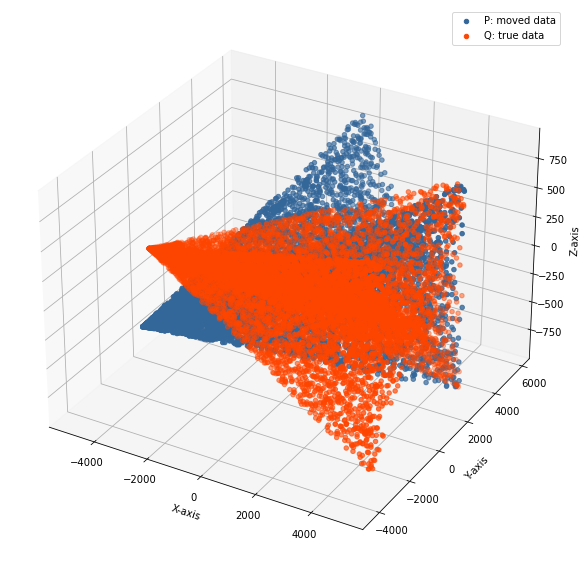

In [20]:
center_P, mean_centered_P = mean_center(P)
center_Q, mean_centered_Q = mean_center(Q)

ax = plot_data(mean_centered_P, mean_centered_Q, "P: moved data", "Q: true data")

plt.show()

#### ICP

Iteration: 100%|██████████| 2/2 [20:32<00:00, 616.32s/it]


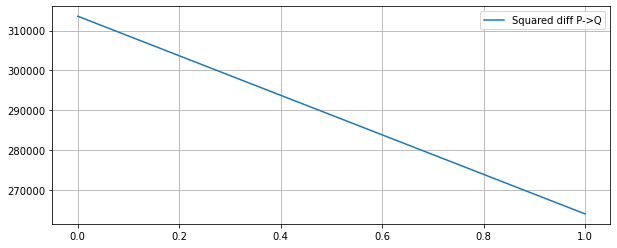

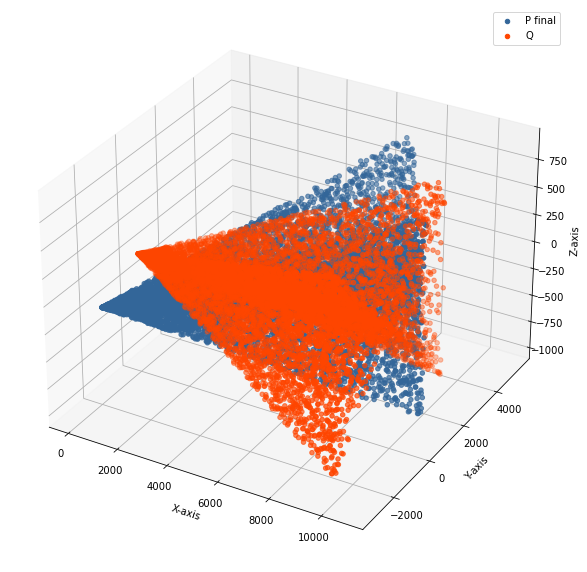

[313576.46567838534, 263996.2717764744]


In [22]:
P_values, norm_values, corresp_values = icp_svd(P, Q, iterations=2)
plot_values(norm_values, label="Squared diff P->Q")
ax = plot_data(P_values[-1], Q, label_1='P final', label_2='Q', markersize_1=15)
plt.show()
print(norm_values)

### RedWood Dataset

In [15]:
import open3d as o3d

raw_color = o3d.io.read_image("./00000.jpg")
raw_depth = o3d.io.read_image("./00000.png")

rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(raw_color, raw_depth)
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

P = np.array(np.asarray(pcd.points)).T

raw_color = o3d.io.read_image("./00004.jpg")
raw_depth = o3d.io.read_image("./00004.png")

rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(raw_color, raw_depth)
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

Q = np.array(np.asarray(pcd.points)).T

In [16]:
min_points =  min(P.shape[1], Q.shape[1])
P, Q = P[:, :min_points], Q[:, :min_points]

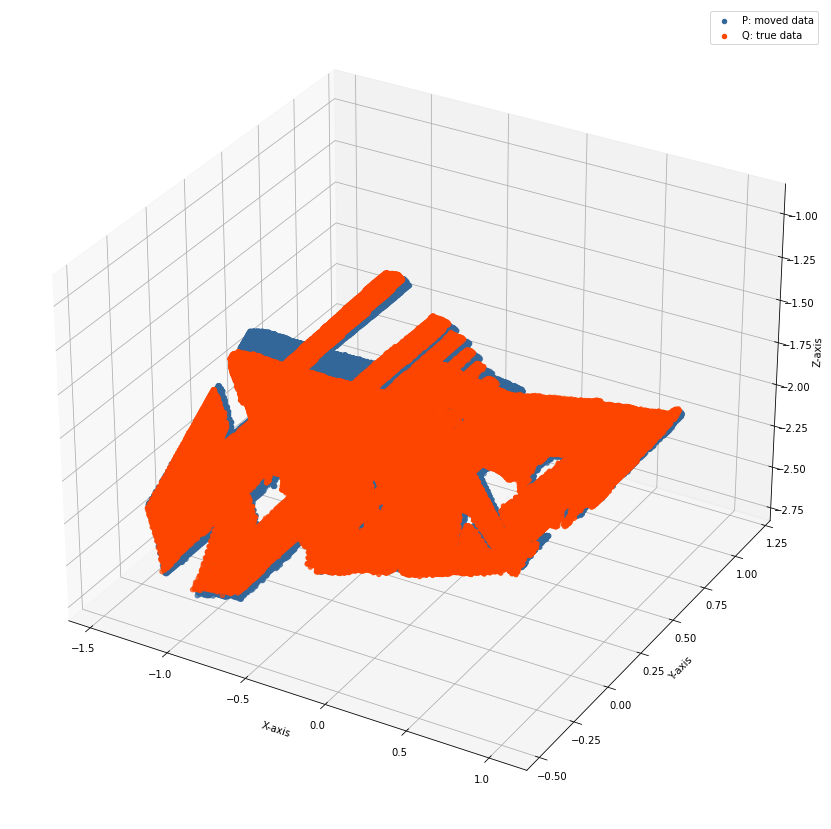

In [17]:
plot_data(P, Q, "P: moved data", "Q: true data")
plt.ioff()
plt.show()

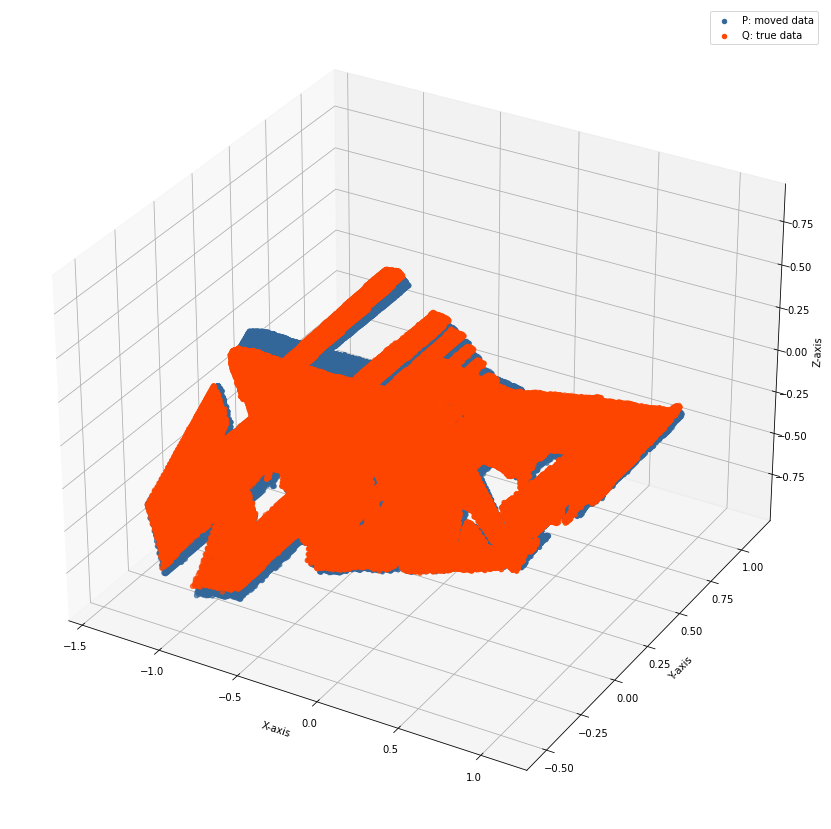

In [25]:
center_P, mean_centered_P = mean_center(P)
center_Q, mean_centered_Q = mean_center(Q)

ax = plot_data(mean_centered_P, mean_centered_Q, "P: moved data", "Q: true data")

plt.show()

#### ICP

In [ ]:
P_values, norm_values, corresp_values = icp_svd(P, Q, iterations=1)
plot_values(norm_values, label="Squared diff P->Q")
ax = plot_data(P_values[-1], Q, label_1='P final', label_2='Q', markersize_1=15)
plt.show()
print(norm_values)

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

### Own Dataset

In [19]:
pcd_load = o3d.io.read_point_cloud("left.ply")
P = np.asarray(pcd_load.points).T

pcd_load = o3d.io.read_point_cloud("right.ply")
Q = np.asarray(pcd_load.points).T

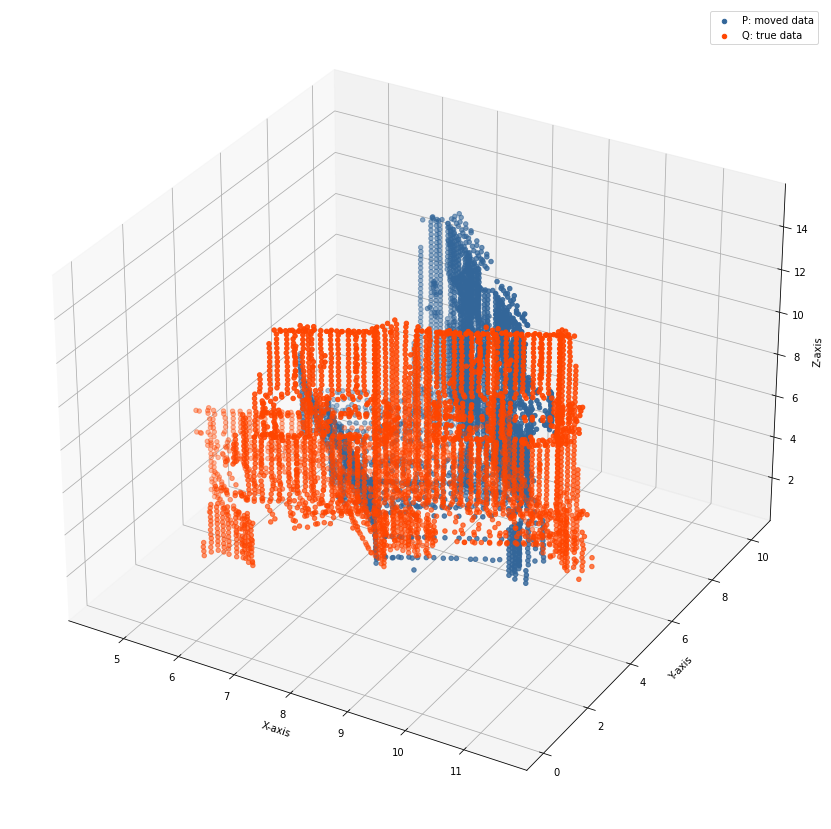

In [20]:
plot_data(P, Q, "P: moved data", "Q: true data")
plt.ioff()
plt.show()

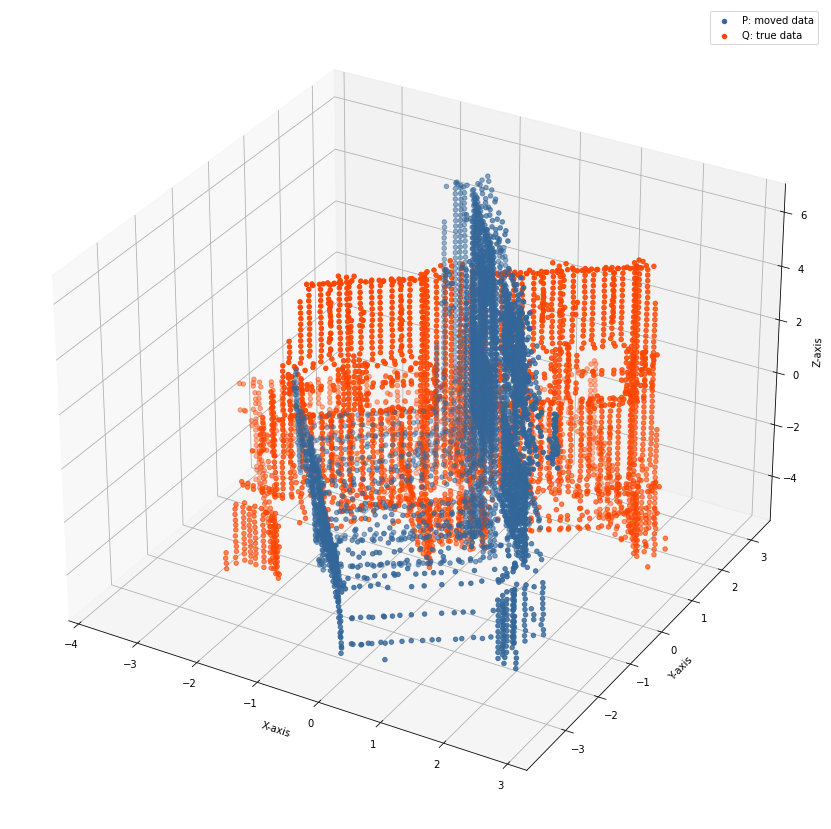

In [21]:
center_P, mean_centered_P = mean_center(P)
center_Q, mean_centered_Q = mean_center(Q)

ax = plot_data(mean_centered_P, mean_centered_Q, "P: moved data", "Q: true data")

plt.show()

Iteration: 100%|██████████| 20/20 [27:55<00:00, 83.79s/it]


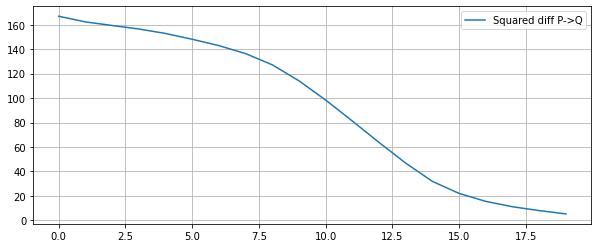

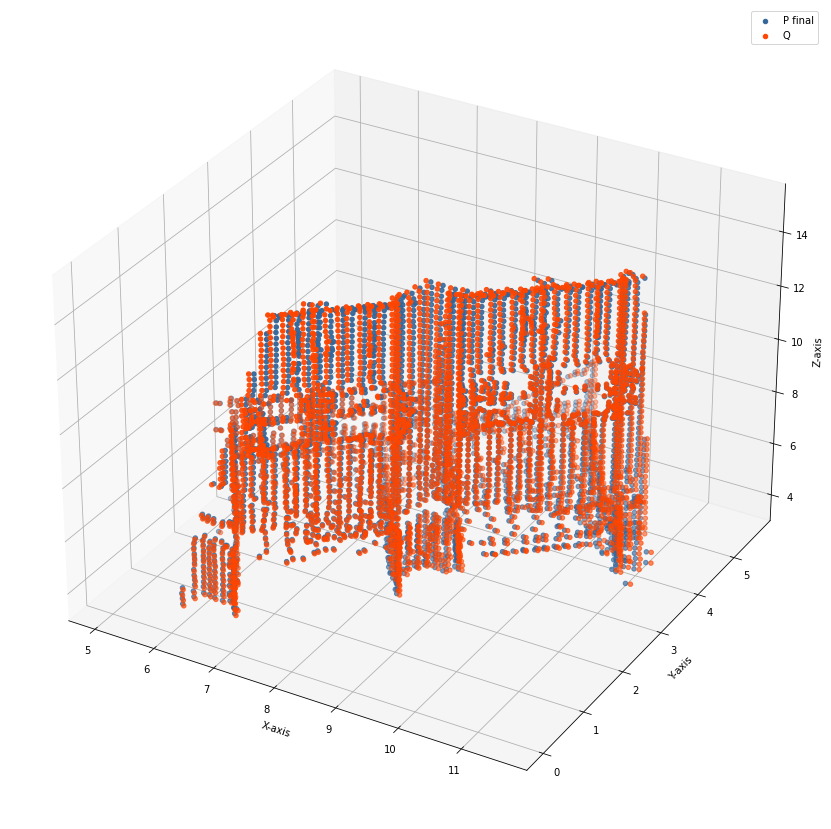

[166.92406957250617, 162.29119488748594, 159.36268801851696, 156.51322344087697, 152.83793421215637, 148.1004919038804, 142.908636781301, 136.36163157241756, 127.20826515607166, 114.12075630162146, 98.36751537767944, 81.21529188586454, 63.70737010913731, 46.77585077638764, 31.83452431141227, 22.02386114312724, 15.509114358275198, 11.136684074131741, 7.98413617467391, 5.2738512015983865]


In [22]:
P_values, norm_values, corresp_values = icp_svd(P, Q, iterations=20)
plot_values(norm_values, label="Squared diff P->Q")
ax = plot_data(P_values[-1], Q, label_1='P final', label_2='Q', markersize_1=15)
plt.show()
print(norm_values)